<div align="center">

# ***CA2 - Genetic***

**Parsa KafshduziBukani - 810102501**

</div>


# 📘 Table of Contents

* **[Genetic Algorithm](#genetic-algorithm)**
  - [Section 1: Definitions](#section-1:-definitions)
  - [Section 2: Initial Population Creation](#section-2:-initial-population-creation)
  - [Section 3: Fitness Evaluation Criteria](#section-3:-fitness-evaluation-criteria)
  - [Section 4: Implementation of Selection, Crossover, and Mutation](#section-4:-implementation-of-selection,-crossover,-and-mutation)
  - [Section 6: Genetic Algorithm and Evolution](#section-6:-genetic-algorithm-and-evolution)

* **[Experimental Results and Analysis](#experimental-results-and-analysis)**
  - [Population Size Comparison](#population-size-comparison)
  - [Crossover Method Comparison](#crossover-method-comparison)
  - [Selection Method Comparison](#selection-method-comparison)
  - [Evaluation Method Comparison](#evaluation-method-comparison)
  - [Target Function Approximation](#target-function-approximation)

* **[Questions](#questions)**

<!-- <a id='imports'></a> -->
# **Genetic Algorithm**

In [1]:
import matplotlib.pyplot as plt
import random
import itertools
import numpy as np

In [2]:
# algorithm parameters
population_sizes = [50, 100, 200]
numCoeffs = 41
generations = 250
mutationRate = 0.15
mutationRange = 0.1
functionRange = (-np.pi, np.pi)
sampleCount = 100

In [3]:
# These functions are given as samples to use in the algorithm
def getTargetFunction(functionName="sin_cos"):
    def sinCosFunction(t):
        """Target function: sin(2πt) + 0.5*cos(4πt)."""
        return np.sin(2 * np.pi * t) + 0.5 * np.cos(4 * np.pi * t)

    def linearFunction(t):
        """Simple linear function: y = 2t + 1."""
        return 2 * t + 1

    def quadraticFunction(t):
        """Quadratic function: y = 4t^2 - 4t + 2."""
        return 4 * (t**2) - 4 * t + 2

    def cubicFunction(t):
        """Cubic function: y = 8t^3 - 12t^2 + 6t."""
        return 8 * (t**3) - 12 * (t**2) + 6 * t

    def gaussianFunction(t):
        """Gaussian function centered at t=0.5."""
        mu = 0.5
        sigma = 0.1  # Adjust sigma to control the width of the peak
        return np.exp(-((t - mu) ** 2) / (2 * sigma**2))

    def squareWaveFunction(t):
        """Approximation of a square wave. Smoothed for better Fourier approximation."""
        return 0.5 * (np.sign(np.sin(2 * np.pi * t)) + 1)

    def sawtoothFunction(t):
        """Sawtooth wave, normalized to [0, 1]."""
        return (t * 5) % 1

    def complexFourierFunction(t):
        return (
            np.sin(2 * np.pi * t)
            + 0.3 * np.cos(4 * np.pi * t)
            + 0.2 * np.sin(6 * np.pi * t)
            + 0.1 * np.cos(8 * np.pi * t)
        )

    def polynomialFunction(t):
        return 10 * (t**5) - 20 * (t**4) + 15 * (t**3) - 4 * (t**2) + t + 0.5

    functionOptions = {
        "sin_cos": sinCosFunction,
        "linear": linearFunction,
        "quadratic": quadraticFunction,
        "cubic": cubicFunction,
        "gaussian": gaussianFunction,
        "square_wave": squareWaveFunction,
        "sawtooth": sawtoothFunction,
        "complex_fourier": complexFourierFunction,
        "polynomial": polynomialFunction,
    }

    selectedFunction = functionOptions.get(functionName.lower())
    if selectedFunction:
        return selectedFunction

In [12]:
# generate samples
tSamples = np.linspace(functionRange[0], functionRange[1], sampleCount)
fSamples = getTargetFunction()(tSamples)

## **Section 1: Definitions**

In this section, we will define the genetic representation of our problem:

- **Gene**: A gene is a single Fourier coefficient, one of `a_0, a_1, ..., a_20, b_1, ..., b_20`, represented as a real number in `[-A, A]`. Each gene corresponds to a parameter that shapes the Fourier series approximation.

- **Chromosome**: A chromosome is a candidate solution, encoded as a sequence of 41 coefficients (genes):
[a_0, a_1, ..., a_20, b_1, ..., b_20]

In [4]:
A = 10
GENE_MIN = -A
GENE_MAX = A
NUM_A = (numCoeffs - 1)//2 + 1
NUM_B = (numCoeffs - 1)//2
CHROMOSOME_LENGTH = NUM_A + NUM_B

class Chromosome:
    def __init__(self, genes=None):
        if genes is None:
            self.genes = np.random.uniform(GENE_MIN, GENE_MAX, CHROMOSOME_LENGTH)
        else:
            self.genes = np.array(genes)
            
        self.fitness = None

    def mutate(self, mutation_rate):
        for i in range(CHROMOSOME_LENGTH):
            if random.random() < mutation_rate:
                self.genes[i] += np.random.uniform(-mutationRange, mutationRange)
                self.genes[i] = np.clip(self.genes[i], GENE_MIN, GENE_MAX)

## **Section 2: Initial Population Creation**

three population sizes 50, 100, and 200 are selected to balance exploration and computational cost. These sizes allow us to study how population diversity affects convergence and solution quality.

In [5]:
populations = {size: np.array([Chromosome() for _ in range(size)]) for size in population_sizes}

<a id='step02'></a>  

## **Section 3: Fitness Evaluation Criteria**

To evaluate how well each chromosome approximates the target function using Fourier coefficients \([a_0, a_1, ..., a_{20}, b_1, ..., b_{20}]\), we compare the generated outputs with 100 sampled target values. Below are three error metrics considered:

> ### Root Mean Square Error (RMSE)
- **Formula:**  
  $$
  \text{rmse} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (f_{\text{approx}}(t_i) - f_i)^2}
  $$
- **Highlights:** Penalizes large errors, provides a smooth overall fit, and is widely used in regression tasks.

> ### Mean Absolute Error (MAE)
- **Formula:**  
  $$
  \text{MAE} = \frac{1}{N} \sum_{i=1}^{N} \left| f_{\text{approx}}(t_i) - f_i \right|
  $$
- **Highlights:** Robust to outliers, treats all deviations equally.

> ### Maximum Absolute Error (MaxAE)
- **Formula:**  
  $$
  \text{MaxAE} = \max_i \left| f_{\text{approx}}(t_i) - f_i \right|
  $$
- **Highlights:** Captures worst-case error, but ignores general fit quality.  
  

We use **MAE** as the main fitness metric because it provides a balanced measure of approximation quality across all sampled points, treating all errors linearly without overly emphasizing large deviations.

Fitness is evaluated using an external function that computes the MAE between the chromosome’s Fourier approximation and the sampled target function. **Lower MAE = better fitness.**

In [6]:
class FitnessEvaluator:
    def __init__(self, t_samples, f_samples, T = 2*np.pi):
        self.t_samples = t_samples
        self.f_samples = f_samples
        self.T = T

    def __compute_fourier_series(self, chromosome):
        a_coeffs = chromosome.genes[:NUM_A]
        b_coeffs = chromosome.genes[NUM_A:]
        result = np.full_like(self.t_samples, a_coeffs[0])
        for n in range(1, NUM_A):
            result += a_coeffs[n] * np.cos(2 * np.pi * n * self.t_samples / self.T)
            result += b_coeffs[n - 1] * np.sin(2 * np.pi * n * self.t_samples / self.T)
        return result

    def _rmse(self, chromosome):
        approx = self.__compute_fourier_series(chromosome)
        chromosome.fitness = np.sqrt(np.mean((approx - self.f_samples) ** 2))
        return chromosome.fitness

    def _mae(self, chromosome):
        approx = self.__compute_fourier_series(chromosome)
        chromosome.fitness = np.mean(np.abs(approx - self.f_samples))
        return chromosome.fitness

    def _maxae(self, chromosome):
        approx = self.__compute_fourier_series(chromosome)
        chromosome.fitness = np.max(np.abs(approx - self.f_samples))
        return chromosome.fitness

    def evaluate(self, chromosome, method="rmse"):
        if method == "rmse":
            return self._rmse(chromosome)
        elif method == "mae":
            return self._mae(chromosome)
        elif method == "maxae":
            return self._maxae(chromosome)


## **Section 4: Implementation of Selection, Crossover, and Mutation**

> ### Selection
To evolve better solutions in a genetic algorithm, we must carefully select parent chromosomes for reproduction. Selection balances *exploitation of good solutions* and *exploration of new ones*. The following strategies are implemented:

1. Tournament Selection
    - Randomly picks `k` individuals from the population and selects the one with the best fitness.  
    - Well-suited for problems with varying fitness scales or noisy evaluations.

2. Roulette Wheel Selection
    - Assigns selection probabilities based on inverse fitness—fitter chromosomes are more likely to be chosen.  
    - Maintains diversity and gives all individuals a chance to be selected, however, Sensitive to large fitness differences or scaling issues.

3. Rank-Based Selection
    - Ranks individuals based on fitness and assigns selection probabilities linearly from best to worst.  
    - Reduces bias from raw fitness values, stabilizing the selection process.  

> ### Crossover
Crossover combines two parent chromosomes to create offspring, aiming to inherit beneficial traits from both. We use three strategies:

1. Single-Point Crossover
    - A random crossover point is selected. Genes before the point are taken from one parent, and genes after the point from the other.

2. Two-Point Crossover
    - Two random crossover points are selected. The segment between these points is swapped between the two parents.

3. Uniform Crossover
    - Each gene is chosen independently from either parent with a 50% chance.

> ### Mutation
Mutation introduces small random changes to a chromosome's genes to maintain diversity and prevent premature convergence.

- Each gene has a chance (defined by `mutation_rate`) to change slightly.
- The change is a small random value, keeping the gene within valid bounds (`GENE_MIN` to `GENE_MAX`).
- You can find the code for mutation in [this cell](#step02).  

In [ ]:
class Selection:
    def __init__(self, method="rank"):
        self.method = method

    @staticmethod
    def _tournament(population, k=4):
        tournament = np.random.choice(population, size=k, replace=False)
        return min(tournament, key=lambda c: c.fitness)

    @staticmethod
    def _roulette(population):
        fitnesses = np.array([c.fitness for c in population])
        scores = 1 / (fitnesses + (1e-8))
        probabilities = scores / scores.sum()
        return np.random.choice(population, p=probabilities)

    @staticmethod
    def _rank_based(population):
        sorted_population = sorted(population, key=lambda c: c.fitness)
        ranks = np.arange(len(population), 0, -1)
        probabilities = ranks / ranks.sum()
        return np.random.choice(sorted_population, p=probabilities)
    
    def select(self, population):
        if self.method == "tournament":
            return self._tournament(population)
        elif self.method == "roulette":
            return self._roulette(population)
        else:
            return self._rank_based(population)
        

class Crossover:
    @staticmethod
    def single_point(parent1, parent2):
        point = random.randint(1, CHROMOSOME_LENGTH - 1)
        child1_genes = np.concatenate((parent1.genes[:point], parent2.genes[point:]))
        child2_genes = np.concatenate((parent2.genes[:point], parent1.genes[point:]))

        return Chromosome(child1_genes), Chromosome(child2_genes)

    @staticmethod
    def uniform(parent1, parent2, swap_prob=0.5):
        child1_genes = np.copy(parent1.genes)
        child2_genes = np.copy(parent2.genes)
        for i in range(CHROMOSOME_LENGTH):
            if random.random() < swap_prob:
                child1_genes[i], child2_genes[i] = child2_genes[i], child1_genes[i]

        return Chromosome(child1_genes), Chromosome(child2_genes)
    
    @staticmethod
    def two_point(parent1, parent2):
        point1 = random.randint(0, CHROMOSOME_LENGTH - 2)
        point2 = random.randint(point1 + 1, CHROMOSOME_LENGTH - 1)

        child1_genes = np.concatenate((
            parent1.genes[:point1],
            parent2.genes[point1:point2],
            parent1.genes[point2:]
        ))

        child2_genes = np.concatenate((
            parent2.genes[:point1],
            parent1.genes[point1:point2],
            parent2.genes[point2:]
        ))

        return Chromosome(child1_genes), Chromosome(child2_genes)
    

## **Section 6: Genetic Algorithm and Evolution**

To evolve Fourier series coefficients that approximate a target function, we integrate all key components into a `GeneticAlgorithm` class. This class coordinates population initialization, fitness evaluation, selection, crossover, mutation, and progression through generations.

### **Evolution Process**
1. **Initialize Population**: Generate random chromosomes.
2. **Evaluate Fitness**: Compute fitness using the chosen metric.
3. **Selection**: Select parent chromosomes using the chosen metric.
4. **Crossover**: Generate children by combining parents' genes using the chosen metric.
5. **Mutation**: Slightly alter genes with a certain probability.
6. **Replacement**: Form a new population for the next generation.
7. **Repeat**: Iterate over multiple generations to evolve better solutions.

After several generations, the best chromosome approximates the target function more accurately, minimizing the fitness metric (e.g., RMSE).  
The design supports modular experimentation with different fitness strategies, selection and crossover.


In [8]:
class GeneticAlgorithm:
    def __init__(self, population, fitness_evaluator, selection, crossover_method="single_point", mutation_rate=mutationRate):
        self.population = population
        self.fitness_evaluator = fitness_evaluator
        self.selection = selection
        self.crossover_method = crossover_method
        self.mutation_rate = mutation_rate

        self.history = []
        self.best_chromosome = None

    def evolve(self, generations=generations, evaluation_method="rmse"):
        for generation in range(generations):
            for chromosome in self.population:
                self.fitness_evaluator.evaluate(chromosome, method=evaluation_method)

            best_in_generation = min(self.population, key=lambda c: c.fitness)
            self.history.append(best_in_generation.fitness)

            new_population = []

            while len(new_population) < len(self.population):
                parent1 = self.selection.select(self.population)
                parent2 = self.selection.select(self.population)

                if self.crossover_method == "single_point":
                    child1, child2 = Crossover.single_point(parent1, parent2)
                elif self.crossover_method == "uniform":
                    child1, child2 = Crossover.uniform(parent1, parent2)
                else:
                    child1, child2 = Crossover.two_point(parent1, parent2)

                child1.mutate(self.mutation_rate)
                child2.mutate(self.mutation_rate)

                new_population.extend([child1, child2])

            self.population = np.array(new_population[:len(self.population)])

        for chromosome in self.population:
            self.fitness_evaluator.evaluate(chromosome, method=evaluation_method)

        self.best_chromosome = min(self.population, key=lambda c: c.fitness)


# **Experimental Results and Analysis**

In [9]:
crossover_methods = ["single_point", "two_point", "uniform"]
selection_methods = ["roulette", "rank", "tournament"]
evaluation_methods = ["maxae", "mae", "rmse"]
population_size_default = 100

## Population Size Comparison

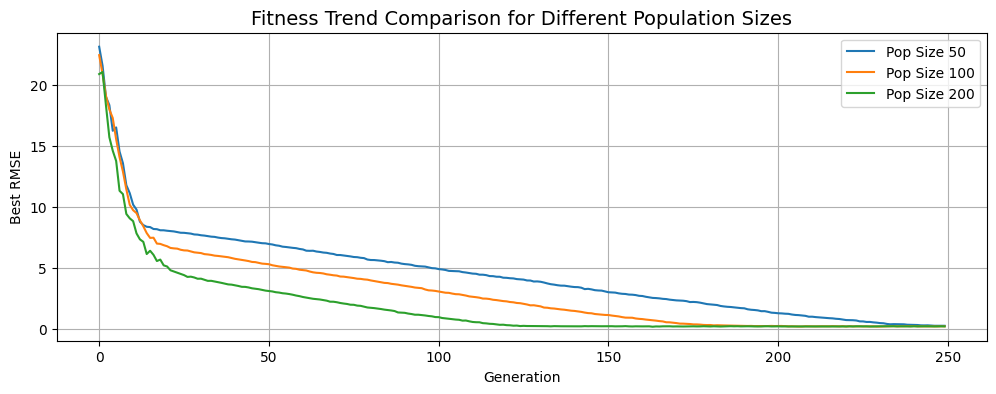

In [22]:
fitness_evaluator = FitnessEvaluator(tSamples, fSamples)

plt.figure(figsize=(12, 4))
plt.title("Fitness Trend Comparison for Different Population Sizes", fontsize=14)

for i, population_size in enumerate(population_sizes):    
    ga = GeneticAlgorithm(populations[population_size], fitness_evaluator, Selection("tournament"), crossover_method="uniform")
    ga.evolve(generations=generations, evaluation_method="rmse")
    
    plt.plot(ga.history, label=f'Pop Size {population_size}')

plt.xlabel('Generation')
plt.ylabel('Best RMSE')
plt.grid(True)
plt.legend()
plt.show()


## Crossover Method Comparison

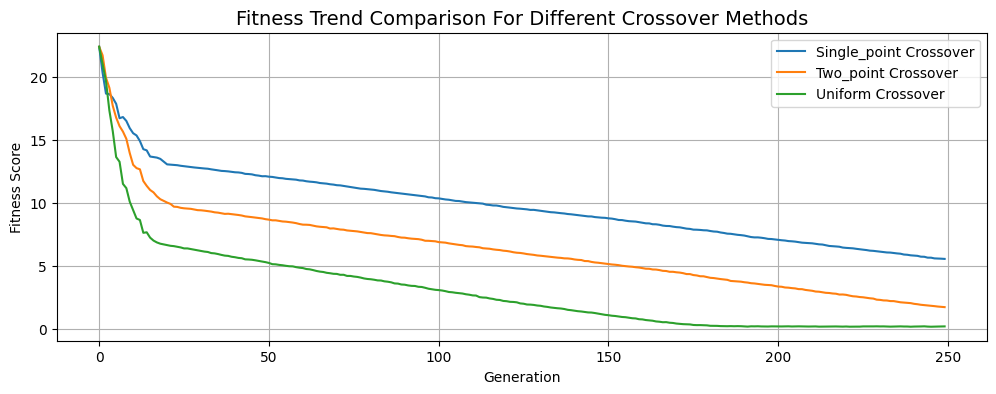

In [24]:
plt.figure(figsize=(12, 4))
plt.title("Fitness Trend Comparison For Different Crossover Methods", fontsize=14)

for i, method in enumerate(crossover_methods):    
    ga = GeneticAlgorithm(populations[population_size_default], fitness_evaluator, Selection("tournament"), crossover_method=method)
    ga.evolve(generations=generations, evaluation_method="rmse")
    
    plt.plot(ga.history, label=f'{method.capitalize()} Crossover')

plt.xlabel('Generation')
plt.ylabel('Fitness Score')
plt.grid(True)
plt.legend()
plt.show()


## Selection Method Comparison

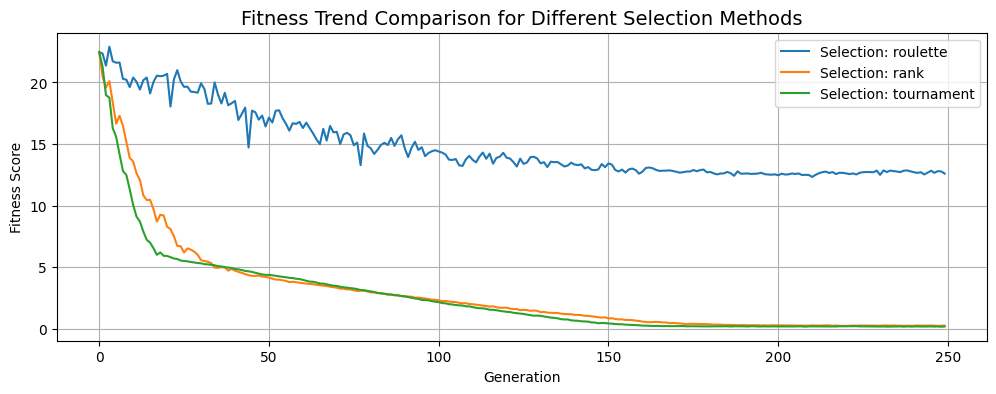

In [ ]:
plt.figure(figsize=(12, 4))
plt.title("Fitness Trend Comparison for Different Selection Methods", fontsize=14)

for method in selection_methods:
    ga = GeneticAlgorithm(populations[population_size_default], fitness_evaluator, Selection(method), crossover_method="uniform")
    ga.evolve(generations=generations, evaluation_method="rmse")
    
    plt.plot(ga.history, label=f'Selection: {method}')

plt.xlabel('Generation')
plt.ylabel('Fitness Score')
plt.grid(True)
plt.legend()
plt.show()


## Evaluation Method Comparison

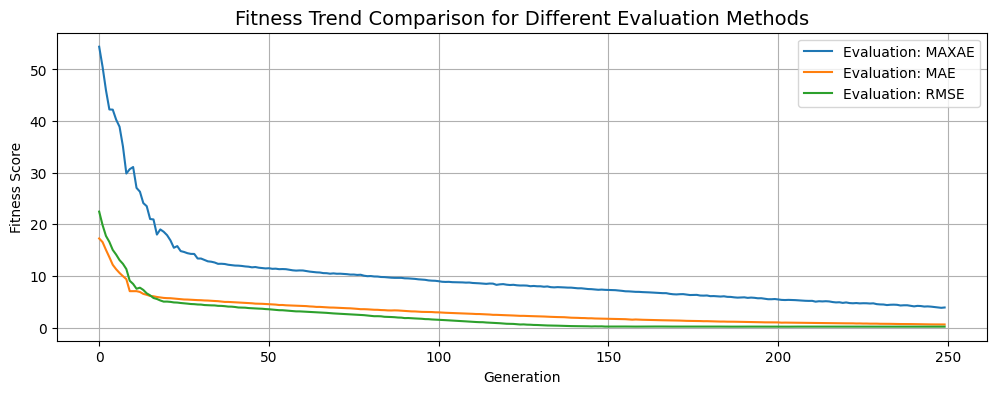

In [53]:
plt.figure(figsize=(12, 4))
plt.title("Fitness Trend Comparison for Different Evaluation Methods", fontsize=14)

for method in evaluation_methods:
    ga = GeneticAlgorithm(populations[population_size_default], fitness_evaluator, Selection("tournament"), crossover_method="uniform")
    ga.evolve(generations=generations, evaluation_method=method)
    
    plt.plot(ga.history, label=f'Evaluation: {method.upper()}')

plt.xlabel('Generation')
plt.ylabel('Fitness Score')
plt.grid(True)
plt.legend()
plt.show()


## Target Function Approximation

In [17]:
target_function = "sin_cos"
crossover_method = "uniform"
selection_method = "tournament"
evaluation_method = "rmse"
population_size = 100

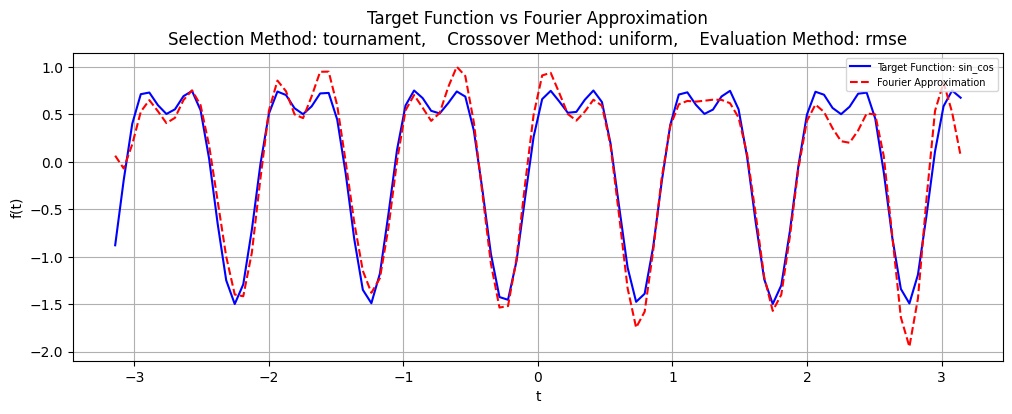

In [18]:
fSamples = getTargetFunction(target_function)(tSamples)
fitness_evaluator = FitnessEvaluator(tSamples, fSamples)

ga = GeneticAlgorithm(populations[population_size], fitness_evaluator, Selection(selection_method), crossover_method=crossover_method)
ga.evolve(generations=generations, evaluation_method=evaluation_method)

best_chromosome = ga.best_chromosome
a_coeffs = best_chromosome.genes[:NUM_A]
b_coeffs = best_chromosome.genes[NUM_A:]

approximated_function = np.full_like(tSamples, a_coeffs[0])
for n in range(1, NUM_A):
    approximated_function += a_coeffs[n] * np.cos(n * tSamples)
    approximated_function += b_coeffs[n - 1] * np.sin(n * tSamples)

plt.figure(figsize=(12, 4))
plt.plot(tSamples, fSamples, label=f'Target Function: {target_function}', color='blue')
plt.plot(tSamples, approximated_function, label='Fourier Approximation', color='red', linestyle='--')
plt.title(f'Target Function vs Fourier Approximation\nSelection Method: {selection_method},    Crossover Method: {crossover_method},    Evaluation Method: {evaluation_method}', fontsize=12)
plt.xlabel('t')
plt.ylabel('f(t)')
plt.legend(loc='upper right', fontsize=7)
plt.grid(True)
plt.show()


# **Questions**

## **1. Calculate the State Space for the Chromosome**
In this project:
- A **gene** is a real number in the range [-A, A], representing one Fourier coefficient.
- A **chromosome** consists of **41 genes**:  
  $$
  [a_0, a_1, \dots, a_{20}, b_1, \dots, b_{20}]
  $$
Assuming each gene is represented with 3 decimal points of precision (i.e., 2000 possible values per gene if \( A = 1 \)):
$$
\text{State Space} = 2000^{41} \approx 1.46 \times 10^{134}
$$

---

## **2. Ideas for Faster Convergence**
1. **Adaptive Mutation Rate**: Start with a higher mutation rate (e.g., 0.1) to explore the search space broadly and gradually decrease it (e.g., to 0.01) as generations progress. This balances exploration early on and exploitation later, allowing the GA to refine Fourier coefficients more quickly toward the optimal solution, reducing the generations needed for convergence.

2. **Hybrid Initialization**: Initialize some chromosomes with coefficients close to expected values (e.g., `a_0 ≈ 0`, `b_1 ≈ 1`, `a_2 ≈ 0.5` for the `sin_cos` function) while keeping others random. This seeds the population with promising solutions, speeding up convergence by starting closer to the target function’s true coefficients.

---

## **3. Selection Strategies in Genetic Algorithms**
1. **Tournament Selection**: Randomly pick a small group of chromosomes (e.g., 3–5) and select the one with the lowest fitness score (MAE in this case). This method balances exploration and exploitation, promoting fitter chromosomes while maintaining diversity, which helps efficiently optimize Fourier coefficients.

2. **Rank-Based Selection**: Sort chromosomes by fitness, assign selection probabilities based on their rank (higher rank = higher chance), and choose parents accordingly. This approach avoids bias from large fitness differences, ensuring steady progress toward better approximations by favoring top-ranked chromosomes without over-focusing on outliers.

---

## **4. Preventing Premature Convergence in Genetic Algorithms**
1. **Maintaining Diversity through Mutation**:
Increasing the mutation rate slightly or applying a non-uniform mutation strategy helps maintain variation in the population. By introducing small random changes to genes, it prevents individuals from becoming too similar and encourages exploration of new areas in the search space.

2. **Fitness Sharing**:
Fitness sharing penalizes individuals that are too similar to others by reducing their effective fitness. This discourages the population from clustering around a single local optimum and encourages the formation of multiple subpopulations exploring different areas of the solution space, thus maintaining genetic diversity.

---

## **5. R-squared Error Function and Its Applicability**

**R² (Coefficient of Determination):** R² measures the proportion of variance in the target data that is predictable from the model. It is defined as:

$$
R^2 = 1 - \frac{\sum (y_i - \hat{y}_i)^2}{\sum (y_i - \bar{y})^2}
$$

Where:
- $ y_i $ are the actual target values,  
- $ \hat{y}_i $ are the predicted values,  
- $ \bar{y} $ is the mean of the actual values.

An R² value **close to 1** indicates a good fit.

**Applicability to This Problem**: R-squared can be useful for evaluating how well the Fourier series approximation captures the target function’s variability. However, since the GA minimizes error directly, R-squared is less suitable as a fitness metric because it doesn’t penalize absolute deviations linearly and may obscure specific coefficient errors.